# College Scorecard and Student Success

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
#Import 2009-2010 data
columns_to_select = ["UNITID", "INSTNM", "CITY", "STABBR", "CONTROL", "REGION", "ADM_RATE", "SAT_AVG",
                     "COSTT4_A", "COSTT4_P", "C150_4", "RET_FT4", "PCTFLOAN", "DEBT_MDN", 
                     "LOAN_EVER", "PCTPELL", "MD_FAMINC", "MD_EARN_WNE_P10"]
null_values = ['NULL', 'PrivacySuppressed']

df_09_10 = pd.read_csv("CollegeScorecard_Raw_Data_04192023\data\MERGED2009_10_PP.csv", usecols=columns_to_select, na_values =null_values)

#Import current data (2021-22)
columns_to_select_c = ["UNITID", "PREDDEG", "LOCALE", "CCBASIC", "CCUGPROF", "CCSIZSET", "CURROPER"]

df_c = pd.read_csv("CollegeScorecard_Raw_Data_04192023\data\MERGED2021_22_PP.csv", usecols=columns_to_select_c, na_values=null_values)

## Data Cleansing

In [3]:
#Rename median earnings column for ease
df_09_10.rename(columns={"MD_EARN_WNE_P10": "MD_EARN"}, inplace=True)

#Filter 2021-22 data to currently operating, predominantly bachelor's-degree granting institutions 
df_c = df_c.loc[(df_c["PREDDEG"] == 3) & (df_c["CURROPER"] == 1) & (~ df_c["CCUGPROF"].isin([0, 4])) & (~ df_c["CCBASIC"].isin([23, 31]))]

In [4]:
#Merge 2021-22 data with 2009-10 data
df = pd.merge(df_09_10, df_c, on="UNITID")

In [5]:
#Create 1 column for cost of attendance for both academic-year and program-year
df["COSTT4"] = df["COSTT4_A"].fillna(df["COSTT4_P"])

#Drop the id, filter and separate cost rows as no longer necessary
df.drop(columns=["UNITID", "PREDDEG", "CURROPER", "COSTT4_A", "COSTT4_P"], inplace=True)

#Drop rows with NA for earnings since that's what I want to analyze
df.dropna(subset=['MD_EARN'], inplace=True)

In [6]:
#Replace numeric values with labels from data dictionary

#Control
control_map = {1: 'Public', 2: 'Private nonprofit', 3: 'Private for-profit'}
df['CONTROL'].replace(control_map, inplace=True)

#Region
region_map = {0: 'U.S. Service Schools', 1: 'New England', 2: 'Mid East', 3: 'Great Lakes', 4: 'Plains', 5: 'Southeast', 6: 'Southwest', 7: 'Rocky Mountains', 8: 'Far West', 9: 'Outlying Areas'}
df['REGION'].replace(region_map, inplace=True)

#Locale
locale_map = {12: 'City: Midsize', 31: 'Town: Fringe', 13: 'City: Small', 23: 'Suburb: Small', 43: 'Rural: Remote', 21: 'Suburb: Large', 41: 'Rural: Fringe', 32: 'Town: Distant', 33: 'Town: Remote', 11: 'City: Large', 42: 'Rural: Distant', 22: 'Suburb: Midsize'}
df['LOCALE'].replace(locale_map, inplace=True)

#CCBASIC
basic_map = {18: "Master's Colleges & Universities: Larger Programs", 15: "Doctoral Universities: Very High Research Activity", 20: "Master's Colleges & Universities: Small Programs", 17: "Doctoral/Professional Universities", 
             22: "Baccalaureate Colleges: Diverse Fields", 21: "Baccalaureate Colleges: Arts & Sciences Focus", 24: "Special Focus Four-Year: Faith-Related Institutions", 19: "Master's Colleges & Universities: Medium Programs",
             16: "Doctoral Universities: High Research Activity", 32: "Special Focus Four-Year: Other Special Focus Institutions", 27: "Special Focus Four-Year: Engineering Schools",
             30: "Special Focus Four-Year: Arts, Music & Design Schools", 29: "Special Focus Four-Year: Business & Management Schools", 26: "Special Focus Four-Year: Other Health Professions Schools", -2: None, 
             25: "Special Focus Four-Year: Medical Schools & Centers", 28: "Special Focus Four-Year: Other Technology-Related Schools", 33: "Tribal Colleges"}
df['CCBASIC'].replace(basic_map, inplace=True)

#CCUGPROF
ugprof_map = {10:"full-time, inclusive, lower transfer-in",  9: "medium full-time, selective, higher transfer-in",  5: "higher part-time", 15: "full-time, more selective, higher transfer-in",
              12: "full-time, selective, lower transfer-in",  7: "medium full-time, inclusive, higher transfer-in", 14: "full-time, more selective, lower transfer-in", 
              11: "full-time, inclusive, higher transfer-in", 13: "full-time, selective, higher transfer-in",  8: "medium full-time, selective, lower transfer-in", 
              6: "medium full-time, inclusive, lower transfer-in", -2: None}
df['CCUGPROF'].replace(ugprof_map, inplace=True)

#CCSIZSET
sizset_map = {14: "medium, highly residential", 15: "large, primarily nonresidential",  6: "very small, primarily nonresidential", 13: "medium, primarily residential", 16: "large, primarily residential",
              9: "small, primarily nonresidential", 11: "small, highly residential", 10: "small, primarily residential",  8: "very small, highly residential", 12: "medium, primarily nonresidential",
              7: "very small, primarily residential", 17: "large, highly residential", -2: None}
df['CCSIZSET'].replace(sizset_map, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613 entries, 0 to 1786
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   INSTNM     1613 non-null   object 
 1   CITY       1613 non-null   object 
 2   STABBR     1613 non-null   object 
 3   CONTROL    1613 non-null   object 
 4   REGION     1613 non-null   object 
 5   ADM_RATE   1434 non-null   float64
 6   SAT_AVG    1272 non-null   float64
 7   PCTPELL    1610 non-null   float64
 8   C150_4     1545 non-null   float64
 9   RET_FT4    1554 non-null   float64
 10  PCTFLOAN   1610 non-null   float64
 11  DEBT_MDN   1597 non-null   float64
 12  LOAN_EVER  1537 non-null   float64
 13  MD_FAMINC  1613 non-null   float64
 14  MD_EARN    1613 non-null   float64
 15  LOCALE     1613 non-null   object 
 16  CCBASIC    1607 non-null   object 
 17  CCUGPROF   1607 non-null   object 
 18  CCSIZSET   1607 non-null   object 
 19  COSTT4     1563 non-null   float64
dtypes: float64(11

## Exploratory Data Analysis

### General Overview

#### Top 5 Median Earnings after 10 years

In [8]:
#Colleges with highest median earnings
df.sort_values('MD_EARN', ascending=False).head()

,INSTNM,CITY,STABBR,CONTROL,REGION,ADM_RATE,SAT_AVG,PCTPELL,C150_4,RET_FT4,PCTFLOAN,DEBT_MDN,LOAN_EVER,MD_FAMINC,MD_EARN,LOCALE,CCBASIC,CCUGPROF,CCSIZSET,COSTT4
786,University of Health Sciences and Pharmacy in ...,Saint Louis,MO,Private nonprofit,Plains,NaN,NaN,NaN,0.5965,0.9114,NaN,11625.0,NaN,75227.0,126700.0,City: Large,Special Focus Four-Year: Other Health Professi...,"full-time, more selective, lower transfer-in","very small, highly residential",NaN
623,MCPHS University,Boston,MA,Private nonprofit,New England,0.7679,1047.0,0.2534,0.7037,0.7808,0.8093,17125.0,0.992371,62818.5,119700.0,City: Large,Special Focus Four-Year: Other Health Professi...,"full-time, inclusive, higher transfer-in","medium, primarily residential",37599.0
883,Albany College of Pharmacy and Health Sciences,Albany,NY,Private nonprofit,Mid East,0.6623,1188.0,0.1574,0.6754,0.8715,0.7307,16000.0,NaN,74602.0,116000.0,City: Small,Special Focus Four-Year: Other Health Professi...,"full-time, more selective, higher transfer-in","small, highly residential",34854.0
140,Samuel Merritt University,Oakland,CA,Private nonprofit,Far West,NaN,NaN,0.2016,0.7143,NaN,0.6166,18750.0,NaN,32958.0,109700.0,City: Large,Special Focus Four-Year: Other Health Professi...,"medium full-time, inclusive, higher transfer-in","small, primarily nonresidential",NaN
1278,University of the Sciences,Philadelphia,PA,Private nonprofit,Mid East,0.5807,1159.0,0.1870,0.6053,0.8523,0.6889,20875.0,0.982328,75897.0,103700.0,City: Large,Doctoral/Professional Universities,"full-time, selective, lower transfer-in","small, primarily residential",43362.0


#### Bottom 5 Median Earnings after 10 years

In [9]:
#Colleges with lowest median earnings
df.sort_values('MD_EARN').head()

,INSTNM,CITY,STABBR,CONTROL,REGION,ADM_RATE,SAT_AVG,PCTPELL,C150_4,RET_FT4,PCTFLOAN,DEBT_MDN,LOAN_EVER,MD_FAMINC,MD_EARN,LOCALE,CCBASIC,CCUGPROF,CCSIZSET,COSTT4
1694,Rabbinical College of Ohr Shimon Yisroel,Brooklyn,NY,Private nonprofit,Mid East,0.9688,NaN,0.8973,0.6000,0.8667,0.0000,NaN,NaN,7734.0,12500.0,City: Large,Special Focus Four-Year: Faith-Related Institu...,"full-time, inclusive, lower transfer-in","very small, primarily nonresidential",11397.0
1023,Yeshiva of Nitra Rabbinical College,Chester,NY,Private nonprofit,Mid East,0.6692,NaN,0.6732,0.3250,0.9306,0.0000,NaN,NaN,13724.0,13200.0,Suburb: Large,Special Focus Four-Year: Faith-Related Institu...,"full-time, inclusive, lower transfer-in","very small, highly residential",12060.0
875,Institute of American Indian and Alaska Native...,Santa Fe,NM,Public,Southwest,NaN,NaN,0.5783,0.8333,0.5806,0.1406,5000.0,0.313187,11327.5,13800.0,Rural: Fringe,Tribal Colleges,"medium full-time, inclusive, higher transfer-in","very small, primarily residential",11709.0
1012,United Talmudical Seminary,Brooklyn,NY,Private nonprofit,Mid East,NaN,NaN,0.8317,0.2231,0.8728,0.0000,NaN,NaN,11198.0,14100.0,City: Large,Special Focus Four-Year: Faith-Related Institu...,"full-time, inclusive, higher transfer-in","medium, primarily nonresidential",11601.0
1026,Yeshivath Viznitz,Monsey,NY,Private nonprofit,Mid East,1.0000,NaN,0.9655,0.7324,1.0000,0.0000,NaN,NaN,11400.0,14500.0,Suburb: Large,Special Focus Four-Year: Faith-Related Institu...,"full-time, inclusive, lower transfer-in","very small, highly residential",10443.0


#### Top 5 lowest cost to future earnings ratio

In [10]:
# Colleges with lowest cost to future earnings ratio
df['cost_to_earnings'] = df['COSTT4'] / df['MD_EARN']
df.sort_values('cost_to_earnings').head()

,INSTNM,CITY,STABBR,CONTROL,REGION,ADM_RATE,SAT_AVG,PCTPELL,C150_4,RET_FT4,...,DEBT_MDN,LOAN_EVER,MD_FAMINC,MD_EARN,LOCALE,CCBASIC,CCUGPROF,CCSIZSET,COSTT4,cost_to_earnings
1013,United States Merchant Marine Academy,Kings Point,NY,Public,U.S. Service Schools,NaN,NaN,0.0537,0.7742,0.8322,...,5406.0,0.816568,87389.0,86000.0,Suburb: Large,Baccalaureate Colleges: Diverse Fields,"full-time, more selective, lower transfer-in","small, highly residential",9010.0,0.104767
805,Bellevue University,Bellevue,NE,Private nonprofit,Plains,NaN,NaN,0.2813,0.4036,0.3824,...,8020.0,0.925900,36811.0,54600.0,Suburb: Large,Master's Colleges & Universities: Larger Programs,"medium full-time, inclusive, higher transfer-in","large, primarily nonresidential",9477.0,0.173571
313,University of Hawaii-West Oahu,Kapolei,HI,Public,Far West,0.8033,864.0,0.1991,NaN,0.6000,...,6601.0,0.690117,25035.0,46000.0,Suburb: Large,Baccalaureate Colleges: Diverse Fields,"medium full-time, inclusive, higher transfer-in","small, primarily nonresidential",8531.0,0.185457
75,California State University-Dominguez Hills,Carson,CA,Public,Far West,0.4974,804.0,0.3906,0.3490,0.6828,...,5542.0,0.710801,20796.0,49900.0,City: Small,Master's Colleges & Universities: Larger Programs,"medium full-time, inclusive, higher transfer-in","large, primarily nonresidential",9400.0,0.188377
1643,University of Puerto Rico-Bayamon,Bayamon,PR,Public,Outlying Areas,0.2415,NaN,0.6037,0.3519,0.9189,...,5000.0,0.092913,19483.0,26300.0,City: Midsize,Baccalaureate Colleges: Diverse Fields,"full-time, inclusive, lower transfer-in","medium, primarily nonresidential",4965.0,0.188783


#### Top 5 highest cost to future earnings ratio

In [11]:
# Colleges with highest cost to future earnings ratio
df.sort_values('cost_to_earnings', ascending=False).head()

,INSTNM,CITY,STABBR,CONTROL,REGION,ADM_RATE,SAT_AVG,PCTPELL,C150_4,RET_FT4,...,DEBT_MDN,LOAN_EVER,MD_FAMINC,MD_EARN,LOCALE,CCBASIC,CCUGPROF,CCSIZSET,COSTT4,cost_to_earnings
934,Manhattan School of Music,New York,NY,Private nonprofit,Mid East,0.3566,NaN,0.1238,0.6538,0.8942,...,14250.0,NaN,65351.0,22400.0,City: Large,"Special Focus Four-Year: Arts, Music & Design ...","full-time, more selective, lower transfer-in","very small, highly residential",49805.0,2.223438
450,Maharishi International University,Fairfield,IA,Private nonprofit,Plains,0.4860,NaN,0.4711,0.5000,0.6000,...,11298.0,0.949791,12900.0,18600.0,Town: Remote,Master's Colleges & Universities: Larger Programs,"medium full-time, inclusive, higher transfer-in","small, primarily residential",32301.0,1.736613
926,The Juilliard School,New York,NY,Private nonprofit,Mid East,0.0711,NaN,0.1700,0.8351,0.9068,...,17125.0,0.939560,74203.0,27200.0,City: Large,"Special Focus Four-Year: Arts, Music & Design ...","full-time, more selective, lower transfer-in","very small, highly residential",43990.0,1.617279
1660,St. John's College,Santa Fe,NM,Private nonprofit,Southwest,0.8519,NaN,0.2483,0.5324,0.7455,...,10000.0,NaN,56125.0,31400.0,Rural: Fringe,Baccalaureate Colleges: Arts & Sciences Focus,"full-time, selective, lower transfer-in","very small, highly residential",49463.0,1.575255
323,School of the Art Institute of Chicago,Chicago,IL,Private nonprofit,Great Lakes,0.8134,1116.0,0.2190,0.6261,0.7522,...,14500.0,0.951686,44362.0,31300.0,City: Large,"Special Focus Four-Year: Arts, Music & Design ...","full-time, selective, higher transfer-in","small, primarily residential",48689.0,1.555559


#### Excluding special focus institutions:

####  Top 10 Median earnings after 10 years

In [12]:
#separate special focus
special = df["CCBASIC"].astype(str).str.startswith("Special")
special_df = df[special]
n_special_df = df[~special]

#non-special top 5
n_special_df.sort_values('MD_EARN', ascending=False).head(10)

,INSTNM,CITY,STABBR,CONTROL,REGION,ADM_RATE,SAT_AVG,PCTPELL,C150_4,RET_FT4,...,DEBT_MDN,LOAN_EVER,MD_FAMINC,MD_EARN,LOCALE,CCBASIC,CCUGPROF,CCSIZSET,COSTT4,cost_to_earnings
1278,University of the Sciences,Philadelphia,PA,Private nonprofit,Mid East,0.5807,1159.0,0.1870,0.6053,0.8523,...,20875.0,0.982328,75897.0,103700.0,City: Large,Doctoral/Professional Universities,"full-time, selective, lower transfer-in","small, primarily residential",43362.0,0.418149
625,Massachusetts Institute of Technology,Cambridge,MA,Private nonprofit,New England,0.1070,1472.0,0.1517,0.9136,0.9733,...,7782.0,0.723404,73409.0,92000.0,City: Midsize,Doctoral Universities: Very High Research Acti...,"full-time, more selective, lower transfer-in","large, highly residential",50100.0,0.544565
67,California Institute of Technology,Pasadena,CA,Private nonprofit,Far West,0.1527,1514.0,0.1118,0.8895,0.9831,...,5500.0,0.783550,86622.0,90200.0,City: Midsize,Doctoral Universities: Very High Research Acti...,"full-time, more selective, lower transfer-in","small, highly residential",48990.0,0.543126
1013,United States Merchant Marine Academy,Kings Point,NY,Public,U.S. Service Schools,NaN,NaN,0.0537,0.7742,0.8322,...,5406.0,0.816568,87389.0,86000.0,Suburb: Large,Baccalaureate Colleges: Diverse Fields,"full-time, more selective, lower transfer-in","small, highly residential",9010.0,0.104767
105,Harvey Mudd College,Claremont,CA,Private nonprofit,Far West,0.3205,1490.0,0.1228,0.9063,0.9109,...,14000.0,0.933333,90577.5,83200.0,Suburb: Large,Baccalaureate Colleges: Arts & Sciences Focus,"full-time, more selective, lower transfer-in","very small, highly residential",50306.0,0.604639
868,Stevens Institute of Technology,Hoboken,NJ,Private nonprofit,Mid East,0.5094,1251.0,0.1599,0.7443,0.8952,...,15162.5,0.971639,82191.5,82000.0,Suburb: Large,Doctoral Universities: High Research Activity,"full-time, more selective, lower transfer-in","medium, primarily residential",48614.0,0.592854
552,Maine Maritime Academy,Castine,ME,Public,New England,0.6234,1000.0,0.2452,0.6667,0.7888,...,15375.0,NaN,65571.0,81900.0,Rural: Distant,Baccalaureate Colleges: Diverse Fields,"full-time, inclusive, lower transfer-in","very small, highly residential",20205.0,0.246703
164,University of Colorado Denver/Anschutz Medical...,Denver,CO,Public,Rocky Mountains,0.6279,1054.0,0.1789,0.4327,0.6956,...,10000.0,0.885294,34706.0,80500.0,City: Large,Doctoral Universities: Very High Research Acti...,"medium full-time, selective, higher transfer-in","large, primarily nonresidential",19592.0,0.243379
217,Georgetown University,Washington,DC,Private nonprofit,Mid East,0.1880,1397.0,0.0948,0.9309,0.9574,...,13385.0,0.948241,68972.5,80200.0,City: Large,Doctoral Universities: Very High Research Acti...,"full-time, more selective, lower transfer-in","large, highly residential",53425.0,0.666147
653,Worcester Polytechnic Institute,Worcester,MA,Private nonprofit,New England,0.6348,NaN,0.1205,0.7956,0.9513,...,17125.0,0.991906,92388.0,79500.0,City: Midsize,Doctoral Universities: High Research Activity,"full-time, selective, lower transfer-in","medium, primarily residential",49350.0,0.620755


#### Bottom 10 Median earnings after 10 years (excluding outlying areas)

In [13]:
#non-special bottom 5
n_special_df.loc[df['REGION'] != 'Outlying Areas'].sort_values('MD_EARN').head(10)

,INSTNM,CITY,STABBR,CONTROL,REGION,ADM_RATE,SAT_AVG,PCTPELL,C150_4,RET_FT4,...,DEBT_MDN,LOAN_EVER,MD_FAMINC,MD_EARN,LOCALE,CCBASIC,CCUGPROF,CCSIZSET,COSTT4,cost_to_earnings
875,Institute of American Indian and Alaska Native...,Santa Fe,NM,Public,Southwest,NaN,NaN,0.5783,0.8333,0.5806,...,5000.0,0.313187,11327.5,13800.0,Rural: Fringe,Tribal Colleges,"medium full-time, inclusive, higher transfer-in","very small, primarily residential",11709.0,0.848478
450,Maharishi International University,Fairfield,IA,Private nonprofit,Plains,0.4860,NaN,0.4711,0.5000,0.6000,...,11298.0,0.949791,12900.0,18600.0,Town: Remote,Master's Colleges & Universities: Larger Programs,"medium full-time, inclusive, higher transfer-in","small, primarily residential",32301.0,1.736613
1365,Sinte Gleska University,Mission,SD,Private nonprofit,Plains,NaN,NaN,0.6002,0.1951,0.8571,...,NaN,NaN,4081.0,19700.0,Rural: Remote,Tribal Colleges,higher part-time,"very small, primarily nonresidential",5293.0,0.268680
1322,Allen University,Columbia,SC,Private nonprofit,Southeast,NaN,NaN,0.8285,0.1888,0.6196,...,9500.0,0.967908,17693.0,20200.0,City: Midsize,Baccalaureate Colleges: Arts & Sciences Focus,"full-time, selective, lower transfer-in","very small, highly residential",18406.0,0.911188
273,Beulah Heights University,Atlanta,GA,Private nonprofit,Southeast,NaN,NaN,0.4588,0.1290,0.3871,...,14250.0,0.948905,19056.5,21400.0,City: Large,Baccalaureate Colleges: Arts & Sciences Focus,higher part-time,"very small, primarily nonresidential",28550.0,1.334112
1494,Goddard College,Plainfield,VT,Private nonprofit,New England,1.0000,NaN,0.3968,0.5455,0.5556,...,12000.0,0.931174,19713.0,21700.0,Rural: Distant,Master's Colleges & Universities: Small Programs,"full-time, inclusive, higher transfer-in","very small, primarily nonresidential",22762.0,1.048940
1197,Pacific Northwest College of Art,Portland,OR,Private nonprofit,Far West,0.5608,NaN,0.3962,0.2903,0.6630,...,12750.0,0.951407,34213.0,21800.0,City: Large,None,None,None,32895.0,1.508945
340,Hebrew Theological College,Skokie,IL,Private nonprofit,Great Lakes,0.9067,1013.0,0.4209,0.0577,0.0640,...,5500.0,0.132316,34422.0,22000.0,City: Small,Baccalaureate Colleges: Arts & Sciences Focus,"full-time, inclusive, higher transfer-in","very small, highly residential",32360.0,1.470909
1695,Florida National University-Main Campus,Hialeah,FL,Private for-profit,Southeast,NaN,NaN,0.9000,0.5071,0.7778,...,8500.0,0.555300,11964.0,22300.0,Suburb: Large,Master's Colleges & Universities: Medium Programs,"medium full-time, inclusive, higher transfer-in","small, primarily nonresidential",22116.0,0.991749
334,East-West University,Chicago,IL,Private nonprofit,Great Lakes,NaN,NaN,0.6746,0.2302,0.3166,...,3841.0,0.923520,11978.5,22600.0,City: Large,Baccalaureate Colleges: Arts & Sciences Focus,"full-time, inclusive, lower transfer-in","very small, primarily nonresidential",24525.0,1.085177


#### 

#### Correlation heatmap

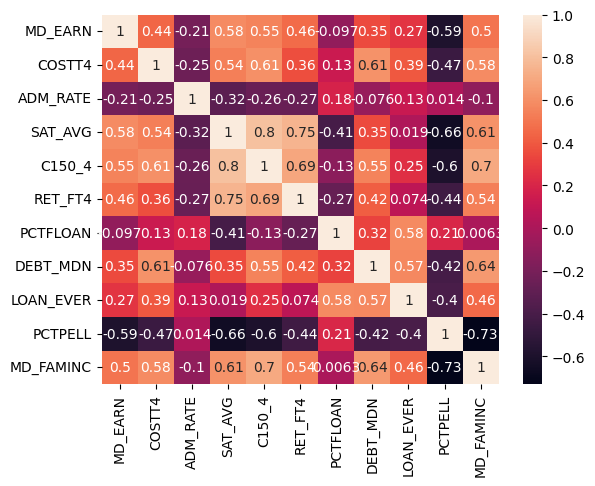

In [14]:
#Correlation heatmap
numeric_factors = df[["MD_EARN", "COSTT4", "ADM_RATE", "SAT_AVG", "C150_4", "RET_FT4", "PCTFLOAN", "DEBT_MDN", 
                     "LOAN_EVER", "PCTPELL", "MD_FAMINC"]]
sns.heatmap(numeric_factors.corr(), annot=True)
plt.show()

Median earnings are most positively correlated with the avg SAT scores, completion rate, and median family income. It is most strongly negatively correlated with the percentage of students recieving Pell grants. Analyze in more detail below. 

### Institution Type

#### Control 

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


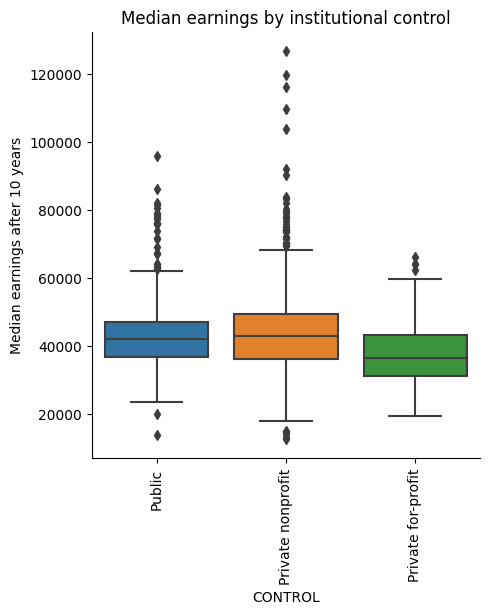

In [15]:
#Function for plotting boxplots
def earnbox(dataframe, x_data, title, x_label=None):
    g = sns.catplot(data=dataframe, x=x_data, y ="MD_EARN", kind="box")
    plt.xticks(rotation=90)
    plt.ylabel('Median earnings after 10 years')
    if x_label is not None:
        plt.xlabel(x_label)
    plt.title(title)    
    plt.show()


# Median Earnings by control
earnbox(df, "CONTROL", "Median earnings by institutional control")

#### Location

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


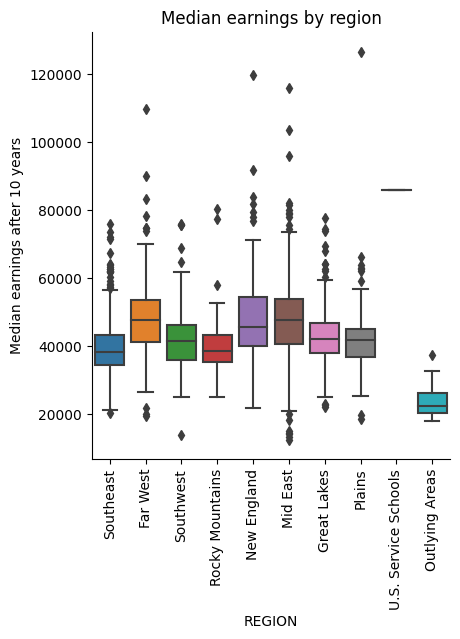

In [16]:
# Median Earnings by region
earnbox(df, "REGION", "Median earnings by region")

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


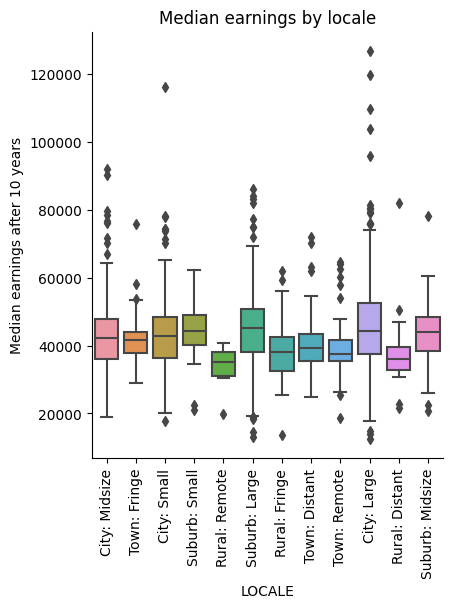

In [17]:
#Median Earnings by Locale
earnbox(df, "LOCALE", "Median earnings by locale")

#### Carnegie Classifications

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


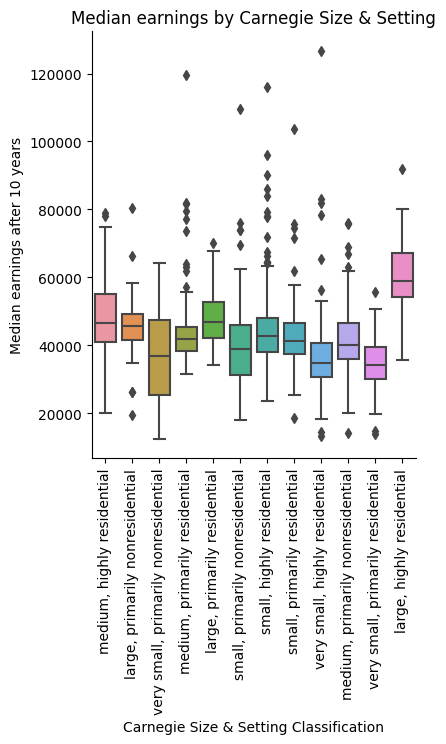

In [18]:
# Median Earnings by Carnegie Size and Setting
earnbox(df, "CCSIZSET", "Median earnings by Carnegie Size & Setting", "Carnegie Size & Setting Classification")

Large, highly residential institutions tend to have higher mean earnings. Let's look at these factors more closely.

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


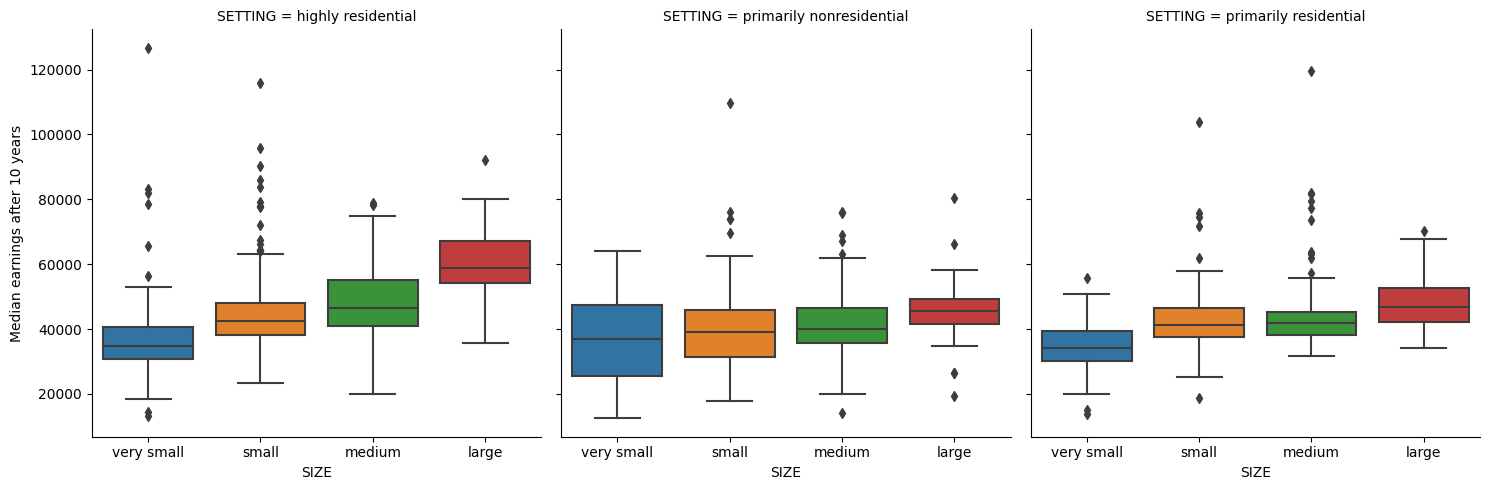

In [19]:
#Size and setting into new columns
df[["SIZE", "SETTING"]] = df["CCSIZSET"].str.split(", ", expand=True)
#Correctly order sizes  
df["SIZE"] = pd.Categorical(df["SIZE"], ["very small", "small", "medium", "large"])


#Plot new data
g = sns.catplot(data=df, x="SIZE", y ="MD_EARN", col="SETTING", kind="box")
g.set_ylabels('Median earnings after 10 years')
plt.show()



There seems to be a slight trend that larger institutions have higher median earnings. This trend is most pronounced in highly residential institutions, with several high outliers for small and very small institutions. 

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


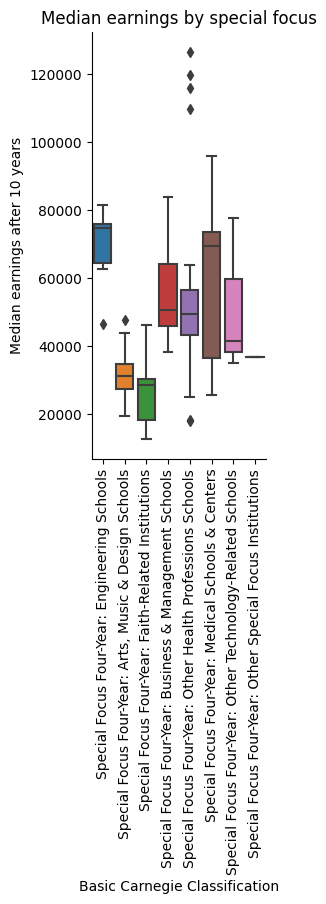

In [20]:
# Special Focus Institutions (already defined aboce)
earnbox(special_df, "CCBASIC", "Median earnings by special focus", "Basic Carnegie Classification")

Engineering schools tend to have the highest median earnings. Medical schools have a very large amount of variability. Arts, Music, and Design schools and Faith-related institutions tend to have the lowest median earnings. 

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


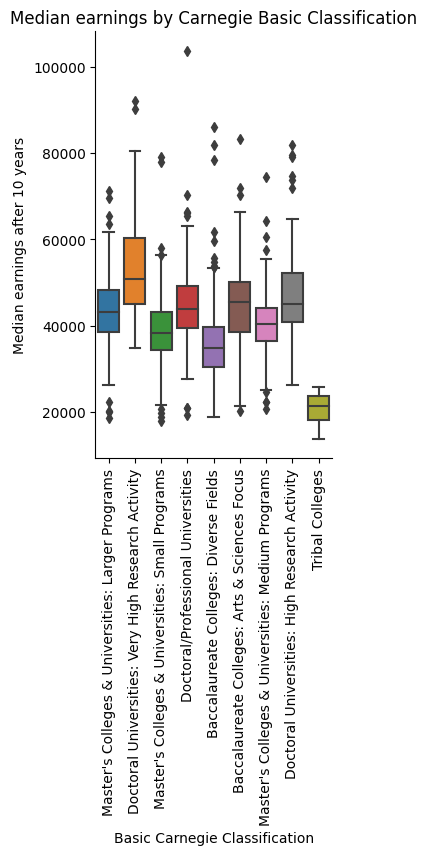

In [21]:
#Other institution types
earnbox(n_special_df, "CCBASIC", "Median earnings by Carnegie Basic Classification", "Basic Carnegie Classification")

While there is a lot of variability and many outliers, Doctoral universities with very high research activity tend to have the highest median earnings. Tribal colleges have the lowest median earnings.

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


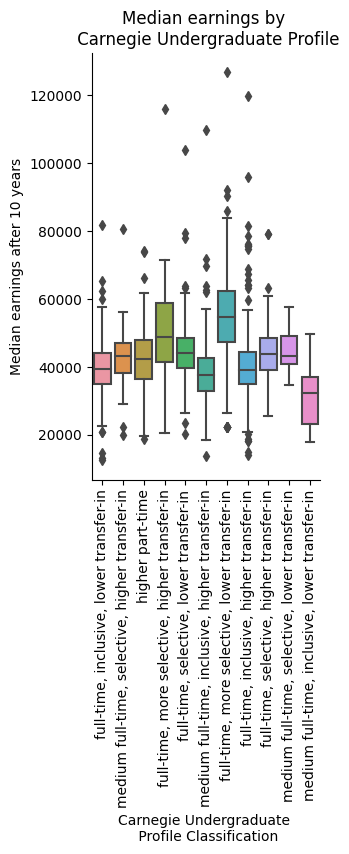

In [22]:
# Median Earnings by Carnegie Undergraduate Profile
earnbox(df, "CCUGPROF", "Median earnings by \n Carnegie Undergraduate Profile", "Carnegie Undergraduate \n Profile Classification" )

Full-time, more selective, lower transfer-in schools have the highest median earnings followed by full-time, more selective, higher transfer-in. There are outliers in most categories. We'll look at selectivity below, so let's examine the other factors separately here.

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


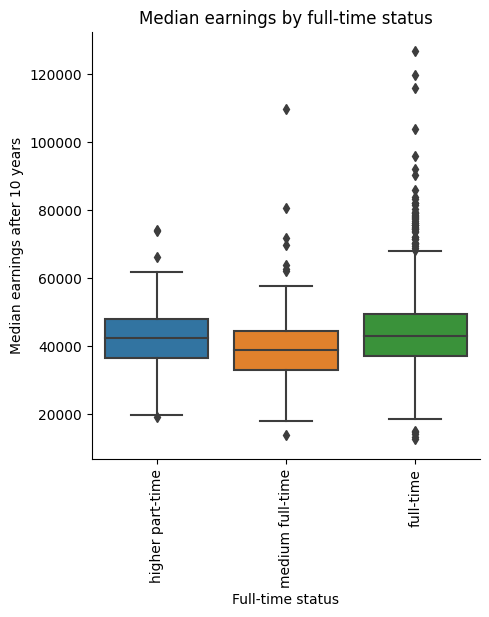

In [23]:
#Size and setting into new columns
df[["FTIME", "SEL", "TRNS"]] = df["CCUGPROF"].str.split(", ", expand=True)
#Correctly order new categories
df["FTIME"] = pd.Categorical(df["FTIME"], ["higher part-time", "medium full-time", "full-time"])
df["TRNS"] = pd.Categorical(df["TRNS"], ["lower transfer-in", "higher transfer-in"])
df["SEL"] = pd.Categorical(df["SEL"], ["inclusive", "selective", "more selective"])

#Plot full-time
earnbox(df, "FTIME", "Median earnings by full-time status", "Full-time status")


Not a big difference here, but there are a lot of outliers for full-time institutions.

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


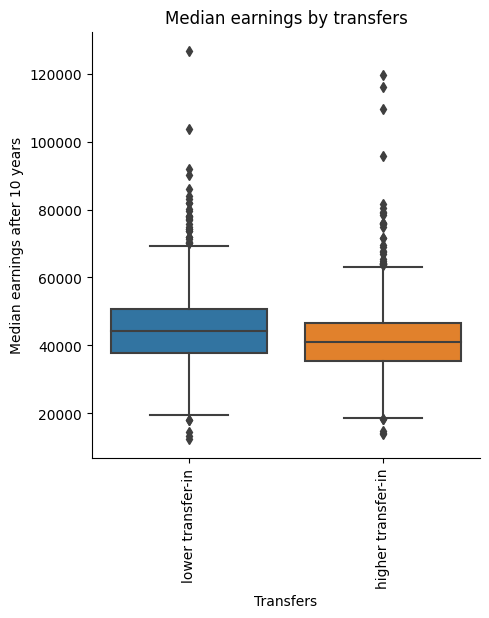

In [24]:
#Plot transfer rate
earnbox(df, "TRNS", "Median earnings by transfers", "Transfers")

Again, not a big difference. It seems that selectivity is driving most of the differences among these categories.

#### Selectivity

C:\Users\salva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


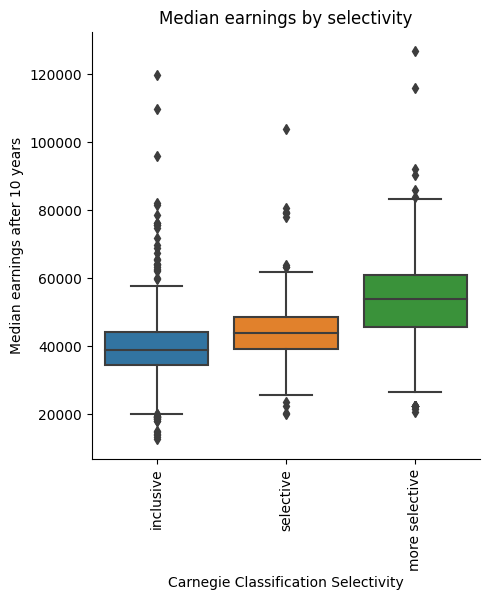

In [25]:
#Plot earnings by Carnegie selectivity
earnbox(df, "SEL", "Median earnings by selectivity", "Carnegie Classification Selectivity")

We see an increase in median earnnigs as the selectivity of the school increases.

                            OLS Regression Results                            
Dep. Variable:                MD_EARN   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     658.7
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          2.24e-117
Time:                        13:48:05   Log-Likelihood:                -13276.
No. Observations:                1272   AIC:                         2.656e+04
Df Residuals:                    1270   BIC:                         2.657e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5100.0759   1946.046     -2.621      0.0

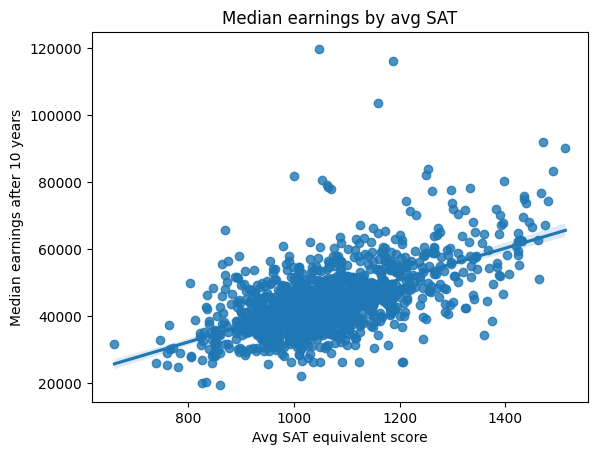

In [26]:
#Define a function for generating scatterplot with regression line and summary stats with statsmodels
def create_OLS(x_values, y_values, x_label, y_label, title):
    #drop na's
    r_df = df.dropna(subset=[x_values])
    #Create scatterplot with regression line
    sns.regplot(x=r_df[x_values], y=r_df[y_values], data=r_df)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    #Fit OLS model with statsmodels
    X = sm.add_constant(r_df[x_values])
    y = r_df[y_values]
    mod = sm.OLS(y, X)
    res = mod.fit()
    print(res.summary())

    #Show plot
    plt.show()

#AVG SAT equivalent scores
create_OLS("SAT_AVG", "MD_EARN", 'Avg SAT equivalent score', 'Median earnings after 10 years', 'Median earnings by avg SAT')

The R-squared value indicates that approximately 33.5% of the variability in median earnings can be explained by the average SAT equivalent scores of students accepted to the school. Schools with higher avg SAT scores tend to have graduates with higher median earnings. The correlation between selectivity and future earnings is interesting since it is an indicator of student success before entering the institution and not a result of the education recieved while there. 

#### Completion Rates

                            OLS Regression Results                            
Dep. Variable:                MD_EARN   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     675.6
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          7.84e-124
Time:                        13:48:06   Log-Likelihood:                -16332.
No. Observations:                1545   AIC:                         3.267e+04
Df Residuals:                    1543   BIC:                         3.268e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.595e+04    693.721     37.403      0.0

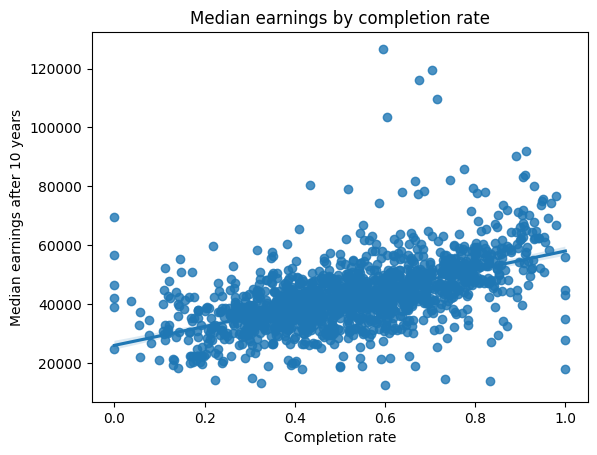

In [27]:
#Completion rate
create_OLS("C150_4", "MD_EARN", "Completion rate", 'Median earnings after 10 years', 'Median earnings by completion rate')

There is a weak positive relationship between completion and retention rates with median earnings as well.

### Financial Factors

#### Pell Grants

                            OLS Regression Results                            
Dep. Variable:                MD_EARN   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     867.5
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          7.48e-153
Time:                        13:48:06   Log-Likelihood:                -16993.
No. Observations:                1610   AIC:                         3.399e+04
Df Residuals:                    1608   BIC:                         3.400e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.535e+04    475.545    116.394      0.0

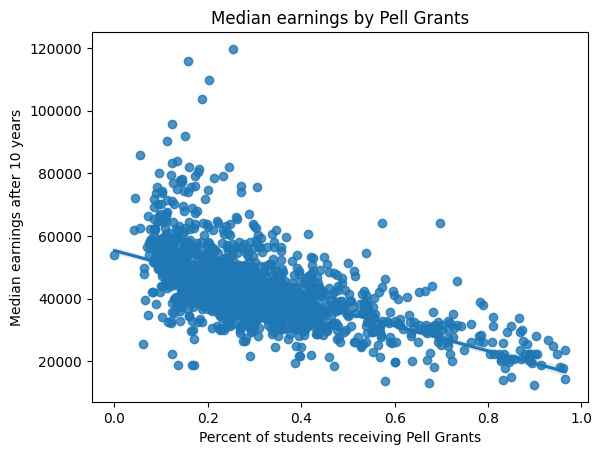

In [28]:
#Pell Grants
create_OLS("PCTPELL", "MD_EARN", "Percent of students receiving Pell Grants", 'Median earnings after 10 years', 'Median earnings by Pell Grants')

There is a negative relationship between the percentage of students receiving Pell Grants and median earnings. The majority of institutions have less than 50% Pell Grant recipients.

### External Factors
#### Median Family Income

                            OLS Regression Results                            
Dep. Variable:                MD_EARN   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     535.5
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          1.63e-102
Time:                        13:48:07   Log-Likelihood:                -17166.
No. Observations:                1613   AIC:                         3.434e+04
Df Residuals:                    1611   BIC:                         3.435e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.942e+04    646.025     45.537      0.0

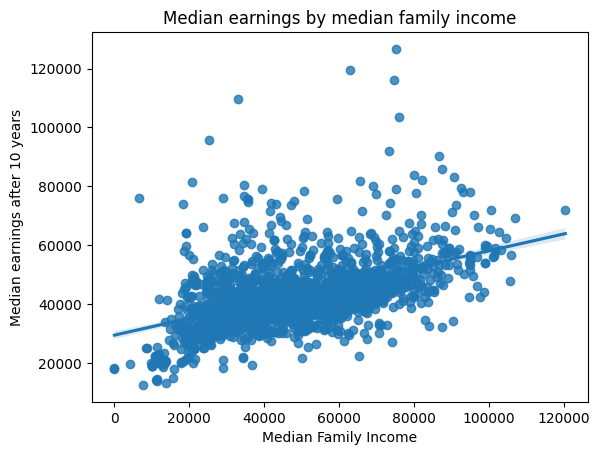

In [29]:
#Median Family Income
create_OLS("MD_FAMINC", "MD_EARN", "Median Family Income", 'Median earnings after 10 years', 'Median earnings by median family income')

There is a weak postitive relationship between median family income and median student earnings.